# Code to compare compute and time resource cost between cpu and gpu
- uses output from pytorch_test_cpu,gpu.py
- CC node: cedar1
- CC gpu: Tesla P100-PCIE-12GB
- CC CPU: doesn't expose RAPL Package and Core modules






In [13]:
import os
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns

In [3]:
project_dir = '../'
data_dir = '{}data/'.format(project_dir)
results_dir = '{}results/'.format(project_dir)

In [15]:

matches

['package_0', 'package_1']

In [35]:
def read_flops(f,mode):
    flops_df = pd.read_csv(f)
    flops_df['mode'] = mode
    return flops_df

def read_joules(f,mode):
    joules_df = pd.read_csv(f)
    jcols = joules_df.columns

    regex = re.compile('package_.')
    package_cols = [string for string in jcols if re.match(regex, string)]

    regex = re.compile('dram_.')
    dram_cols = [string for string in jcols if re.match(regex, string)]
    
    joules_df['package_total'] = joules_df[package_cols].sum(axis=1)
    joules_df['dram_total'] = joules_df[dram_cols].sum(axis=1)
    joules_df['mode'] = mode

    return joules_df

In [45]:
experiment_names = ['test_run','CC_test_run']
proc_modes = ['cpu'] #,'gpu']

jcols = ['experiment_name','duration','package_total','dram_total','mode']
flops_df_concat = pd.DataFrame()
joules_df_concat = pd.DataFrame()
for exp_name in experiment_names:
    for proc_mode in proc_modes:
        flops_csv = '{}{}_flops_{}.csv'.format(results_dir,exp_name,proc_mode)
        joules_csv = '{}{}_joules_{}.csv'.format(results_dir,exp_name,proc_mode)
        flops_df = read_flops(flops_csv,proc_mode)
        flops_df['experiment_name'] = exp_name
        joules_df = read_joules(joules_csv,proc_mode)
        joules_df['experiment_name'] = exp_name
        flops_df_concat = flops_df_concat.append(flops_df)
        joules_df_concat = joules_df_concat.append(joules_df[jcols])


flops_df_concat.head()

,Unnamed: 0,epoch,compute_time,brand,cpu_arch,cpu_count,python_version,gpu_device,model,input_size,init_features,n_channels,FLOPs,n_parameters,mode,experiment_name
0,0,0.0,0.033845,Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz,X86_64,8,3.7.9.final.0 (64 bit),NaN,unet,512,64,1,218.58 GMac,31.04 M,cpu,test_run
1,1,1.0,0.033525,Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz,X86_64,8,3.7.9.final.0 (64 bit),NaN,unet,512,64,1,218.58 GMac,31.04 M,cpu,test_run
2,2,2.0,0.033539,Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz,X86_64,8,3.7.9.final.0 (64 bit),NaN,unet,512,64,1,218.58 GMac,31.04 M,cpu,test_run
3,3,3.0,0.033517,Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz,X86_64,8,3.7.9.final.0 (64 bit),NaN,unet,512,64,1,218.58 GMac,31.04 M,cpu,test_run
4,4,4.0,0.033965,Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz,X86_64,8,3.7.9.final.0 (64 bit),NaN,unet,512,64,1,218.58 GMac,31.04 M,cpu,test_run


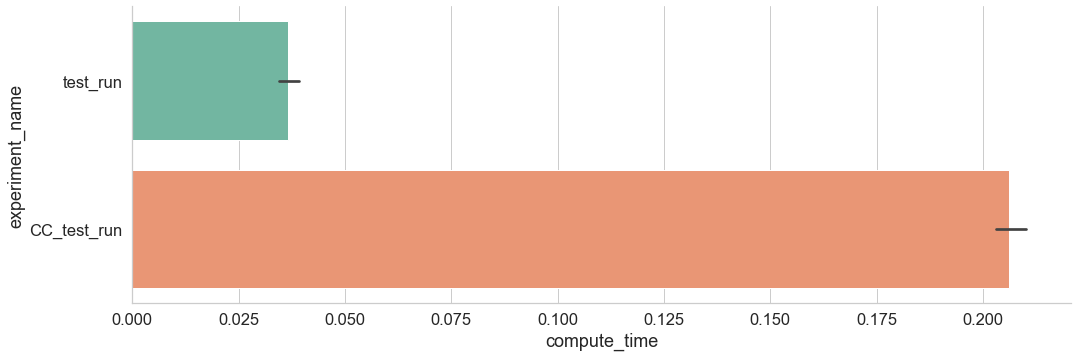

In [46]:
plot_df = flops_df_concat.copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='compute_time', y='experiment_name',  kind='bar', data=plot_df, palette='Set2', aspect=3)


In [47]:
joules_df_concat.head()

,experiment_name,duration,package_total,dram_total,mode
0,test_run,1.988204,57300512.0,3480337.0,cpu
1,test_run,1.970431,57744786.0,3514029.0,cpu
2,test_run,1.968517,57234045.0,3455313.0,cpu
3,test_run,1.968303,57873815.0,3462760.0,cpu
4,test_run,1.994367,57551794.0,3523855.0,cpu


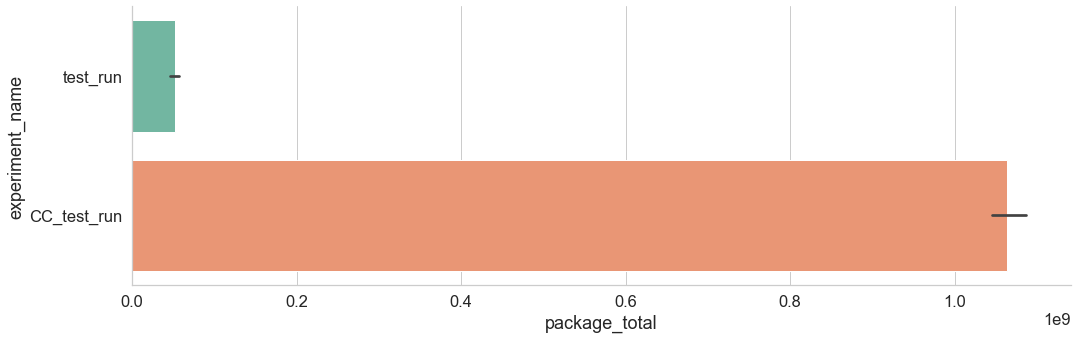

In [48]:
plot_df = joules_df_concat.copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='experiment_name',x='package_total', kind='bar', data=plot_df, palette='Set2',aspect=3)

    # g.set(xscale="log")